# Détectez les bad buzz grace au Deeplearning

In [1]:
import warnings
warnings.simplefilter(action='ignore')
# basic libs
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import unidecode
import gc
# text preprocessing
import nltk
import gensim
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
# simple random forest regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# deeplearning
import tensorflow as tf

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)


### Text preproccessing

On commence par tokéniser le texte (on ne garde que les mots, en supprimant la pontuation, les liens, les nombres ...).
On retire également les "stop-words", c'est-à-dire tous les articles, déterminants, pronoms et mots de liaison.
On applique ensuite deux traitements différents séparément pour comparer leurs performances: la lemmatisation (qui garde seulement la forme canonique des mots, par exemple le féminin singulier) et le stemming (qui garde uniquement le radical des mots). 

In [2]:
done_preprocessing = 1

n_words = 5000 # warning: must be higher later

test_size = 100000
val_size = 100000

lbls = ['Negative', '', '', '', 'Positive']

if not done_preprocessing:
    train_df = pd.read_csv('./data/dataset.csv', names=['target', 'id', 'date', 'flag', 'user', 'text'], encoding='latin-1')
    train_df = train_df[['target', 'text']]
    
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    stop_words = list(nltk.corpus.stopwords.words('english'))
    
    def clean_up(text):
        text = unidecode.unidecode(''.join(c for c in text if not c.isdigit()).replace('\n', '').lower())
        text = text.split()
        for exclude in ['@', '/']:
            text = [w for w in text if not exclude in w]
        text = ' '.join(text)
        tokens = tokenizer.tokenize(text)
        tokens = [w for w in tokens if not w in stop_words and len(w) > 1]
        return " ".join(tokens)
    
    def update_target(tgt):
        return 1 if tgt else 0
    
    train_df["target"] = train_df["target"].apply(update_target)
    
    train_df["text"] = train_df["text"].apply(clean_up)
    
    train_df = train_df[train_df['text'] != ""]
    
    train_df = train_df.sample(frac=1)
    
    train_df.to_csv('./data/preprocessed.csv', index=False)

In [3]:
if not done_preprocessing:
    
    train_df = pd.read_csv('./data/preprocessed.csv')
    
    stemmer = EnglishStemmer()
    lemmatizer = WordNetLemmatizer()

    def stem(text):
        return [w for w in [stemmer.stem(w2) for w2 in text]if len(w) > 1]

    def lem(text):
        return [w for w in [lemmatizer.lemmatize(w2) for w2 in text]if len(w) > 1]
    
    # vanilla
    train_df["text"] = train_df["text"].apply(lambda x: x.split())
    v_dictionary = gensim.corpora.Dictionary(train_df["text"].tolist())
    print(f"Found {len(v_dictionary)} unique tokens in vanilla text")
    v_dictionary.filter_extremes(no_below=20, no_above=0.4, keep_n=n_words)
    v_words = v_dictionary.token2id
    with open("./data/vanilla_vocab.txt", "w") as f:
        for w in v_words:
            f.write(w)
            f.write('\n')
            
    # stemming
    train_df["text_stem"] = train_df["text"].apply(stem)
    s_dictionary = gensim.corpora.Dictionary(train_df["text_stem"].tolist())
    print(f"Found {len(s_dictionary)} unique tokens after stemming")
    s_dictionary.filter_extremes(no_below=20, no_above=0.4, keep_n=n_words)
    s_words = s_dictionary.token2id
    with open("./data/stemming_vocab.txt", "w") as f:
        for w in s_words:
            f.write(w)
            f.write('\n')
    
    # lemmatization
    train_df["text_lem"] = train_df["text"].apply(lem)
    l_dictionary = gensim.corpora.Dictionary(train_df["text_lem"].tolist())
    print(f"Found {len(l_dictionary)} unique tokens after lemmatisation")
    l_dictionary.filter_extremes(no_below=20, no_above=0.4, keep_n=n_words)
    l_words = l_dictionary.token2id
    with open("./data/lemmatization_vocab.txt", "w") as f:
        for w in l_words:
            f.write(w)
            f.write('\n')
    
    def clean_vanilla(tokens):
        return " ".join([t for t in tokens if t in v_words])
    
    def clean_stem(tokens):
        return " ".join([t for t in tokens if t in s_words])
        
    def clean_lem(tokens):
        return " ".join([t for t in tokens if t in l_words])

    # clean new df
    train_df["text"] = train_df["text"].apply(clean_vanilla)
    train_df["text_stem"] = train_df["text_stem"].apply(clean_stem)
    train_df["text_lem"] = train_df["text_lem"].apply(clean_lem)

    train_df = train_df[train_df['text'] != ""]
    train_df = train_df[train_df['text_stem'] != ""]
    train_df = train_df[train_df['text_lem'] != ""]
    
    train_df = train_df.sample(frac=1)
    
    print(f"Final dataframe size: {train_df.shape[0]}")
    
    # make train test split
    test_df = train_df.head(test_size)
    train_df = train_df.tail(train_df.shape[0] - test_size)
    val_df = train_df.head(val_size)
    train_df = train_df.tail(train_df.shape[0] - val_size)
    test_df.to_csv('./data/text_test.csv', index=False)
    val_df.to_csv('./data/text_val.csv', index=False)
    train_df.to_csv('./data/text_train.csv', index=False)
else:
    print("Found 270425 unique tokens in vanilla text\nFound 223960 unique tokens after stemming\nFound 258567 unique tokens after lemmatisation\nFinal dataframe size: 1577584")

Found 270425 unique tokens in vanilla text
Found 223960 unique tokens after stemming
Found 258567 unique tokens after lemmatisation
Final dataframe size: 1577584


In [4]:
if done_preprocessing:
    train_df = pd.read_csv('./data/text_train.csv')
    test_df = pd.read_csv('./data/text_test.csv')
    val_df = pd.read_csv('./data/text_val.csv')
    
train_df.head()

,target,text,text_stem,text_lem
0,0,keep taking mail burning mean,forest keep take mail burn mean,forest keep taking mail burning mean
1,1,com exist ok wallet hurting,com exist ok wallet hurt,com exist ok wallet hurting
2,0,feeling rough would say never drink would lie ...,feel rough would say never drink would lie may...,feeling rough would say never drink would lie ...
3,0,bugs window screen,bug window screen,bug window screen
4,0,really want sing really loud right,realli want sing realli loud right,really want sing really loud right


In [5]:
results_file = f'./results.csv'

if not os.path.isfile(results_file):
    results = pd.DataFrame(columns=['model_name', 'accuracy', 'loss'])
    results.to_csv(results_file, index=False)

def add_result(name, accuracy, loss=None):
    result_df = pd.read_csv(results_file)
    result_df = result_df[result_df["model_name"] != name]
    result_df = result_df.append({"model_name": name, "accuracy": accuracy, "loss": loss}, ignore_index=True)
    result_df.to_csv(results_file, index=False)
    
def get_results():
    result_df = pd.read_csv(results_file)
    print(result_df.head(20))

### Baseline

Le modèle de base servant de références aux autres modèles est une simple régression (random forest) appliquée sur les bag-of-words.

In [6]:
trained = 1

debug = 1

if debug:
    train_df = train_df.head(500000) # 20000 => 5Go for random forest & simple models with 5K vocabulary
    val_df = val_df.head(5000)
    test_df = test_df.head(5000)

In [7]:
if not trained:
    vanilla_vectoriser = CountVectorizer(max_features=n_words)
    train_vectorized = vanilla_vectoriser.fit_transform(train_df["text"].to_list()).toarray()
    test_vectorized = vanilla_vectoriser.transform(test_df["text"].to_list()).toarray()

    stem_vectoriser = CountVectorizer(max_features=n_words)
    train_vectorized_stem = stem_vectoriser.fit_transform(train_df["text_stem"].to_list()).toarray()
    test_vectorized_stem = stem_vectoriser.transform(test_df["text_stem"].to_list()).toarray()

    lem_vectoriser = CountVectorizer(max_features=n_words)
    train_vectorized_lem = lem_vectoriser.fit_transform(train_df["text_lem"].to_list()).toarray()
    test_vectorized_lem = lem_vectoriser.transform(test_df["text_lem"].to_list()).toarray()

    target = train_df["target"].to_list()
    test_target = test_df["target"].to_list()

#### Vanilla

In [8]:
if not debug and not trained:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [100, 1000],
        'max_features': ['sqrt', 'log2']
    }
    forest_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring="accuracy", n_jobs=-1)
    forest_grid.fit(train_vectorized, target)
    print(forest_grid.best_params_)
    print("accuracy :", forest_grid.best_score_)
    forest_params = forest_grid.best_params_
else:
    forest_params = {'max_features': 'sqrt', 'n_estimators': 1000}

In [9]:
if not trained:
    random_forest = RandomForestClassifier(
                    n_estimators=forest_params['n_estimators'],
                    random_state=50,
                    max_features=forest_params['max_features'],
                    verbose=False,
                    n_jobs=-1)
    random_forest.fit(train_vectorized, target)
    joblib.dump(random_forest, "./models/random_forest.joblib")
    
    perf = random_forest.score(test_vectorized, test_target)
    add_result("random_forest", perf)
    
    del random_forest
    gc.collect()

#### Avec stemming

In [10]:
if not debug and not trained:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [100, 1000],
        'max_features': ['sqrt', 'log2']
    }
    forest_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring="accuracy", n_jobs=-1)
    forest_grid.fit(train_vectorized_stem, target)
    print(forest_grid.best_params_)
    print("accuracy :", forest_grid.best_score_)
    forest_params = forest_grid.best_params_
else:
    forest_params = {'max_features': 'sqrt', 'n_estimators': 1000}

In [11]:
if not trained:
    random_forest_stem = RandomForestClassifier(
                    n_estimators=forest_params['n_estimators'],
                    random_state=50,
                    max_features=forest_params['max_features'],
                    verbose=False,
                    n_jobs=-1)
    random_forest_stem.fit(train_vectorized_stem, target)
    joblib.dump(random_forest_stem, "./models/random_forest_stem.joblib")
    
    perf = random_forest_stem.score(test_vectorized_stem, test_target)
    add_result("random_forest_stem", perf)

    del random_forest_stem
    gc.collect()

#### Avec lemmatization

In [12]:
if not debug and not trained:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [100, 1000],
        'max_features': ['sqrt', 'log2']
    }
    forest_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring="accuracy", n_jobs=-1)
    forest_grid.fit(train_vectorized_lem, target)
    print(forest_grid.best_params_)
    print("accuracy :", forest_grid.best_score_)
    forest_params = forest_grid.best_params_
else:
    forest_params = {'max_features': 'sqrt', 'n_estimators': 1000}

In [13]:
if not trained:
    random_forest_lem = RandomForestClassifier(
                    n_estimators=forest_params['n_estimators'],
                    random_state=50,
                    max_features=forest_params['max_features'],
                    verbose=False,
                    n_jobs=-1)
    random_forest_lem.fit(train_vectorized_lem, target)
    
    perf = random_forest_lem.score(test_vectorized_lem, test_target)
    add_result("random_forest_lem", perf)
    
    joblib.dump(random_forest_lem, "./models/random_forest_lem.joblib")
    
    del random_forest_lem
    gc.collect()
    

### Deeplearning

In [14]:
batch_size = 10

BUFFER_SIZE = 1000

AUTOTUNE = tf.data.AUTOTUNE

steps_per_epoch = train_df.shape[0] // (batch_size * 1)

def process_model(model, hist, name, test_dataset):
    # get results
    history = pd.DataFrame(data=hist.history)
    model_performance = model.evaluate(test_dataset)
    model_pred = model.predict(test_dataset)
    test_df[f"{name}_label"] = model_pred
    # save results
    add_result(name, model_performance[1], model_performance[0])
    history.to_csv(f'./models/{name}_history.csv', index=False)
    model.save_weights(f'./models/{name}.h5')
    test_df.to_csv('./labels_df.csv', index=False)

def display_learning_curves(hst):
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(hst[met])
        ax[i].plot(hst['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    
    plt.show()

In [15]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

vocab_vanilla = load_doc("./data/vanilla_vocab.txt")
vocab_vanilla = vocab_vanilla.split()
vocab_vanilla = set(vocab_vanilla)
vocab_stem = load_doc("./data/stemming_vocab.txt")
vocab_stem = vocab_stem.split()
vocab_stem = set(vocab_stem)
vocab_lem = load_doc("./data/lemmatization_vocab.txt")
vocab_lem = vocab_lem.split()
vocab_lem = set(vocab_lem)


In [16]:
# get targets
y_train = np.asarray(train_df["target"].to_list())
y_test = np.asarray(test_df["target"].to_list())
y_val = np.asarray(val_df["target"].to_list())

#### Modèles simples

In [17]:
def train_simple_nn(train_dataset, test_dataset, validation_dataset, name, has_trained=0):
    # vectorize data
    if has_trained:
        vectoriser = joblib.load(f"./models/{name}_vectoriser.joblib")
        train_vectorized = vectoriser.transform(train_dataset).toarray()
        test_vectorized = vectoriser.transform(test_dataset).toarray()
        val_vectorized = vectoriser.transform(validation_dataset).toarray()
    else:
        vectoriser = CountVectorizer(max_features=n_words)
        train_vectorized = vectoriser.fit_transform(train_dataset).toarray()
        test_vectorized = vectoriser.transform(test_dataset).toarray()
        val_vectorized = vectoriser.transform(validation_dataset).toarray()
        joblib.dump(vectoriser, f"./models/{name}_vectoriser.joblib")
     # make tf datasets
    train_ds = tf.data.Dataset.from_tensor_slices((np.asarray(train_vectorized), tf.cast(y_train, tf.int32))).shuffle(BUFFER_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices((np.asarray(test_vectorized), tf.cast(y_test, tf.int32)))
    val_ds = tf.data.Dataset.from_tensor_slices((np.asarray(val_vectorized), tf.cast(y_val, tf.int32))).shuffle(BUFFER_SIZE)
    # preprocess datasets
    train_ds = train_ds.repeat()
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
    # build model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(10, input_dim=np.shape(train_vectorized)[1], activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    if has_trained:
        model.load_weights(f'./models/{name}.h5')
        history = pd.read_csv(f'./models/{name}_history.csv')

    print(model.summary())
    
    model.compile(loss='binary_crossentropy', 
                  optimizer="adam", 
                  metrics=['accuracy'])
    # train model
    hist = model.fit(train_ds,
                     epochs=5,
                     verbose=2,
                     validation_data=val_ds,
                     batch_size=batch_size,
                     steps_per_epoch=steps_per_epoch)
    
    process_model(model, hist, name, test_ds)
    
    # cleaning
    del train_ds
    del test_ds
    del val_ds
    gc.collect()
    

##### Vanilla

In [18]:
model_name = "vanilla_nn"
# train_simple_nn(train_df["text"].to_list(), test_df["text"].to_list(), val_df["text"].to_list(), model_name)

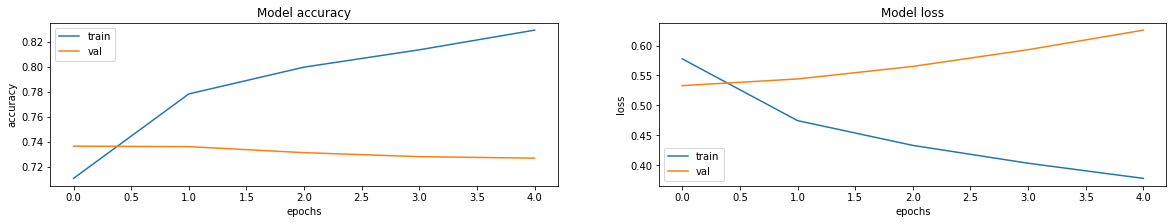

In [19]:
history = pd.read_csv(f'./models/{model_name}_history.csv')
display_learning_curves(history)

##### Stemming

In [20]:
model_name = "stemming_nn"
# train_simple_nn(train_df["text_stem"].to_list(), test_df["text_stem"].to_list(), val_df["text_stem"].to_list(), model_name)

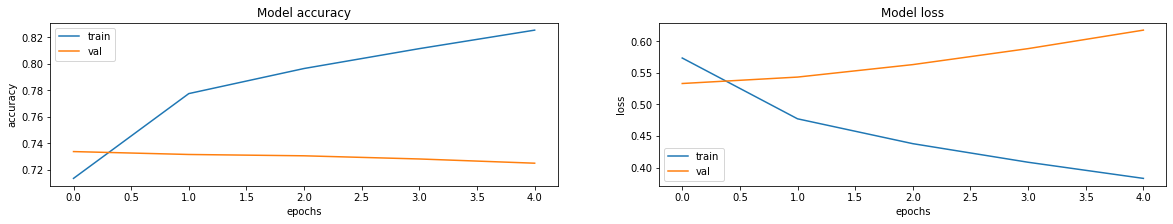

In [21]:
history = pd.read_csv(f'./models/{model_name}_history.csv')
display_learning_curves(history)

##### Lemmatization

In [22]:
model_name = "lemmatization_nn"
# train_simple_nn(train_df["text_lem"].to_list(), test_df["text_lem"].to_list(), val_df["text_lem"].to_list(), model_name)

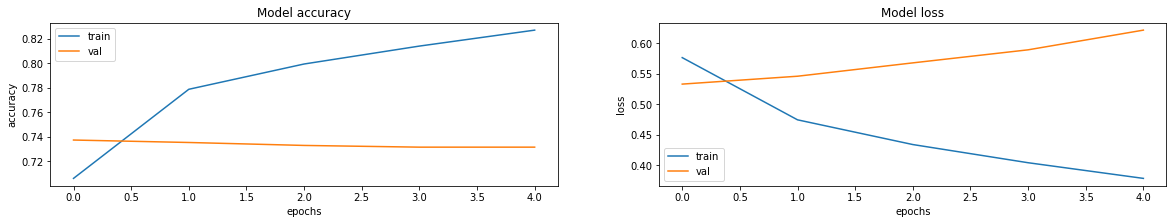

In [23]:
history = pd.read_csv(f'./models/{model_name}_history.csv')
display_learning_curves(history)

<AxesSubplot:xlabel='target', ylabel='Count'>

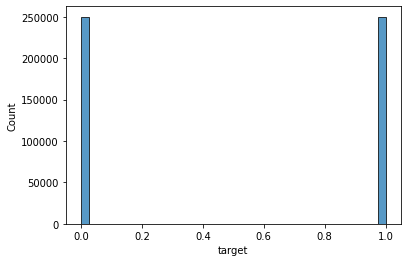

In [24]:
sns.histplot(data=train_df["target"])

#### Utilisation de modèles de plongement de mots

In [25]:
trained = 0

if not trained:
    # get train data
    X_train = train_df["text"].to_list()
    # X_train_stem = train_df["text_stem"].to_list()
    # X_train_lem = train_df["text_lem"].to_list()
    
    # get test data
    X_test = test_df["text"].to_list()
    # X_test_stem = test_df["text_stem"].to_list()
    # X_test_lem = test_df["text_lem"].to_list()
    
    # get validation data
    X_val = val_df["text"].to_list()
    # X_val_stem = val_df["text_stem"].to_list()
    # X_val_lem = val_df["text_lem"].to_list()
    def encoder(data_train, data_test, data_val):
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=n_words)
        tokenizer.fit_on_texts(data_train)
        encoded_train = tokenizer.texts_to_sequences(data_train)
        encoded_test = tokenizer.texts_to_sequences(data_test)
        encoded_val = tokenizer.texts_to_sequences(data_val)
        max_len = max([len(s.split()) for s in data_train])
        train_data = np.asarray(tf.keras.preprocessing.sequence.pad_sequences(encoded_train, maxlen=max_len, padding='post'))
        test_data = np.asarray(tf.keras.preprocessing.sequence.pad_sequences(encoded_test, maxlen=max_len, padding='post'))
        val_data = np.asarray(tf.keras.preprocessing.sequence.pad_sequences(encoded_val, maxlen=max_len, padding='post'))

        return train_data, test_data, val_data, max_len, tokenizer

    X_train, X_test, X_val, vanilla_input_dim, vanilla_tokenizer = encoder(X_train, X_test, X_val)
    # X_train_stem, X_test_stem, X_val_stem, stem_input_dim, stem_tokenizer = encoder(X_train_stem, X_test_stem, X_val_stem)
    # X_train_lem, X_test_lem, X_val_lem, lem_input_dim, lem_tokenizer = encoder(X_train_lem, X_test_lem, X_val_lem)

    # make tf datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, tf.cast(y_train, tf.int32))).shuffle(BUFFER_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, tf.cast(y_test, tf.int32)))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, tf.cast(y_val, tf.int32))).shuffle(BUFFER_SIZE)
    # preprocess datasets
    train_ds = train_ds.repeat()
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

##### Glove

In [26]:
glove_dim = 200

In [27]:
def load_embedding(filename):
    file = open(filename, encoding="utf8")
    lines = file.readlines()
    file.close()
    embedding = dict()
    for line in lines:
        parts = line.split()
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding
 
def get_weight_matrix(embedding, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, glove_dim))
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

vocab_size = len(vanilla_tokenizer.word_index) + 1
raw_embedding = load_embedding(f'./models/glove.6B.{glove_dim}d.txt')
embedding_vectors = get_weight_matrix(raw_embedding, vanilla_tokenizer.word_index)
embedding_layer = tf.keras.layers.Embedding(vocab_size, glove_dim, weights=[embedding_vectors], input_length=vanilla_input_dim, trainable=False)

In [28]:
model_name = "glove_cnn"

def train_glove_model(has_trained=0):

    glove_model = tf.keras.models.Sequential()
    glove_model.add(embedding_layer)
    glove_model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
    glove_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    glove_model.add(tf.keras.layers.Flatten())
    glove_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    print(glove_model.summary())
    
    glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist = glove_model.fit(train_ds,
                           epochs=10,
                           verbose=2,
                           validation_data=val_ds,
                           batch_size=batch_size,
                           steps_per_epoch=steps_per_epoch)
    
    process_model(glove_model, hist, model_name, test_ds)

train_glove_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 200)           999800    
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 128)           128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1409      
Total params: 1,129,337
Trainable params: 129,537
Non-trainable params: 999,800
_________________________________________________________________
None
Epoch 1/10
50000/50000 - 155s - loss: 0.5242 - accuracy: 0.7387 - val_loss: 0.5165 - val_accuracy: 0.74

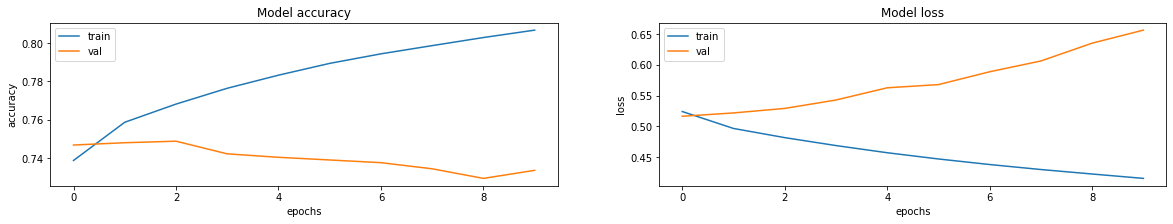

In [29]:
history = pd.read_csv(f'./models/{model_name}_history.csv')
display_learning_curves(history)

##### Glove + LSTM

In [30]:
model_name = "glove_lstm_nn"

def train_glove_lstm_model(has_trained=0):
    
    glove_model = tf.keras.models.Sequential()
    glove_model.add(embedding_layer) 
    glove_model.add(tf.keras.layers.LSTM(128,return_sequences=True,dropout=0.2))
    glove_model.add(tf.keras.layers.GlobalMaxPooling1D())
    glove_model.add(tf.keras.layers.Dense(64,activation='relu')) 
    glove_model.add(tf.keras.layers.Dense(1,activation='sigmoid')) 

    print(glove_model.summary())
    
    glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    hist = glove_model.fit(train_ds,
                           epochs=10,
                           verbose=2,
                           validation_data=val_ds,
                           batch_size=batch_size,
                           steps_per_epoch=steps_per_epoch)
    
    process_model(glove_model, hist, model_name, test_ds)

train_glove_lstm_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 200)           999800    
_________________________________________________________________
lstm (LSTM)                  (None, 26, 128)           168448    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,176,569
Trainable params: 176,769
Non-trainable params: 999,800
_________________________________________________________________
None
Epoch 1/10
50000/50000 - 241s - loss: 0.5046 - accuracy: 0.7509 - val_loss: 0.4865 - val_accuracy: 0.

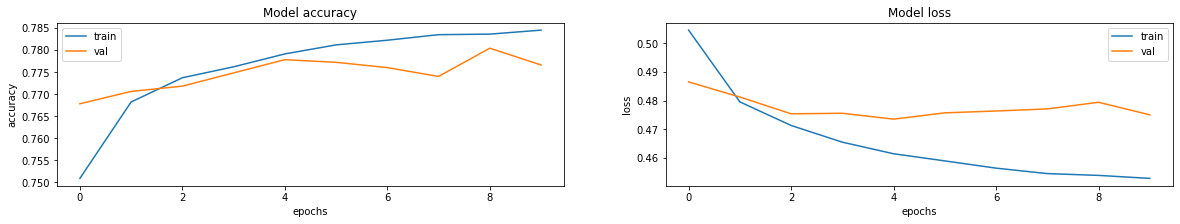

In [31]:
history = pd.read_csv(f'./models/{model_name}_history.csv')
display_learning_curves(history)

##### Word2vec

In [32]:
# word2vec_pretrained = gensim.models.KeyedVectors.load_word2vec_format('./models/GoogleNews-vectors-negative300.bin', binary=True)

In [33]:
get_results()

           model_name  accuracy      loss
0       random_forest    0.7218       NaN
1  random_forest_stem    0.7262       NaN
2   random_forest_lem    0.7188       NaN
3          vanilla_nn    0.7284  0.617380
4         stemming_nn    0.7352  0.611000
5    lemmatization_nn    0.7318  0.617316
6           glove_cnn    0.7502  0.606238
7       glove_lstm_nn    0.7774  0.465412
